### Creating Fake Data ###

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '../../')
import pandas as pd
from sequence_analysis import seq_tables, read_sequences, insilica_sequences

In [3]:
import numpy as np
import time

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
seq = insilica_sequences.generate_sequence(seq_len=300)
seq

'GGTAATAAAGAAGATTTAAGCTGACGCGCGAGCCCTTCTCTCAAGGCCTGCAGTGGCCCCGGGAGCCTACCTGTATCTGAGTCGATGGGATACAAACCGCTCCCAAATCAATCGCGACCACCATCTCGCTGCGAGAGATTGCTTGGTTACATCTAAAATCTAATGTCCTATCAGACCAAAGACCACTCCATTGTCTCTGGTGGATACTGGATCCAGGGTCTCCTAGGTCGTTCGGCCGGGTTAAGCAGTTACCCCATGAAGGGAGGAATCGCTCGATGCTTCCGGACCTGGTAATTTCAC'

In [6]:
# create a set of sequences based on the seq above
# erorr prone rate = 0.01 (1%, dont mutate the first position)
# takes 6 seconds to generate 1 million sequences of a 100mer sequence
# each element in matrix is 1 byte , so total size = seq x bases 
t1 = time.time()
lib = insilica_sequences.generate_library(
    seq,
    10000, 
    error_prone_rate=0.01, 
    no_error_prone_pos=[1]
)
t2 = time.time()
t2-t1

0.1130068302154541

In [7]:
# we could also generate a site saturated library (NNN at each position)
ss_pos = [5,6,7, 10,11,12, 20,21,22]
t1 = time.time()
lib = insilica_sequences.generate_library(
    seq,
    10000, 
    error_prone_rate=0.01, 
    no_error_prone_pos=[1],
    ss_pos=ss_pos
)
t2 = time.time()
t2-t1

0.1370081901550293

In [8]:
np.unique(lib[:, 4], return_counts=True)

(array([b'A', b'C', b'G', b'T'], 
       dtype='|S1'), array([2468, 2541, 2520, 2471], dtype=int64))

In [9]:
# now we can generate a set of fake quality scores for the library (assuming they were sequenced)
q_r1 = insilica_sequences.add_quality_scores(lib, read_type='r1', bulk_size=10000)
q_r2 = insilica_sequences.add_quality_scores(lib, read_type='r2', bulk_size=10000)

In [10]:
(q_r1).view(np.uint8) - 33

array([[35, 35, 35, ..., 19, 17, 15],
       [35, 35, 35, ..., 19, 17, 20],
       [35, 35, 35, ..., 19, 17, 15],
       ..., 
       [35, 35, 35, ..., 14, 17, 10],
       [35, 35, 35, ..., 19, 17, 15],
       [35, 40, 35, ..., 19, 12, 15]], dtype=uint8)

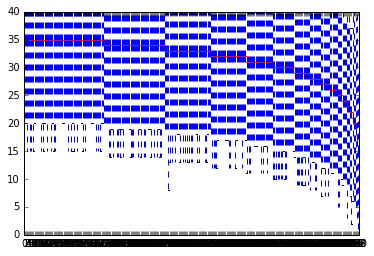

In [11]:
# plot quality scores
pd.DataFrame(q_r1.view(np.uint8) - 33).plot(kind='box')

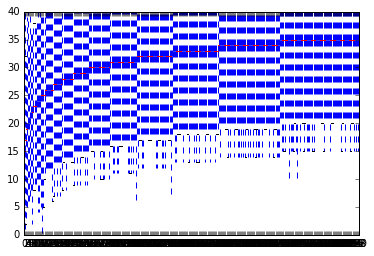

In [12]:
# plot quality scores
pd.DataFrame(q_r2.view(np.uint8) - 33).plot(kind='box')

In [13]:
lib_seqs = lib.view('S300').squeeze().astype('U')
r1_qual = q_r1.view('S300').squeeze().astype('U')
with open('../tests/files/r1_10k.fastq', 'w') as w:
    for i in range(lib_seqs.shape[0]):
        w.write('\n'.join([
            '@seq_' + str(i),
            lib_seqs[i],
            '+',
            r1_qual[i]
        ]
    ) + '\n'
)
        
del lib_seqs
del r1_qual

In [14]:
lib_seqs = lib.view('S300').squeeze().astype('U')
with open('../tests/files/r1_10k.fa', 'w') as w:
    for i in range(lib_seqs.shape[0]):
        w.write('\n'.join([
            '>seq_' + str(i),
            lib_seqs[i],            
        ]
    ) + '\n'
)
        
del lib_seqs

In [15]:
from Bio.Seq import Seq
lib_seqs = lib.view('S300').squeeze().astype('U')
r2_qual = q_r2.view('S300').squeeze().astype('U')
with open('../tests/files/r2_10k.fastq', 'w') as w:
    for i in range(lib_seqs.shape[0]):
        w.write('\n'.join([
            '@seq_' + str(i),
            str(Seq(lib_seqs[i]).reverse_complement()),
            '+',
            r2_qual[i][::-1]
        ]
    ) + '\n'
)
        
del lib_seqs
del r2_qual